<a href="https://colab.research.google.com/github/RaeganGutierrez/Customer-Segmentation/blob/main/UCI_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the dataset from UCI repository
uci = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
retail = pd.read_excel(uci)

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [32]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [33]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [34]:
# Check for missing values in each column
missing = retail.isnull().sum()
print(missing)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [35]:
# Clean data

# Drop rows with missing CustomerID
retail.dropna(subset=['CustomerID'], inplace=True)
retail['CustomerID'] = retail['CustomerID'].astype(int)

# Remove rows with negative Quantity and Price
retail = retail[(retail['Quantity'] > 0) & (retail['UnitPrice'] > 0)]

print(retail.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object


In [36]:
# Aggregate RFM values
date = max(retail['InvoiceDate']) + pd.DateOffset(days=1)
retail['Total'] = retail['Quantity'] * retail['UnitPrice']
rfm = retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total': 'sum'
})

rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Total': 'Monetary'}, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


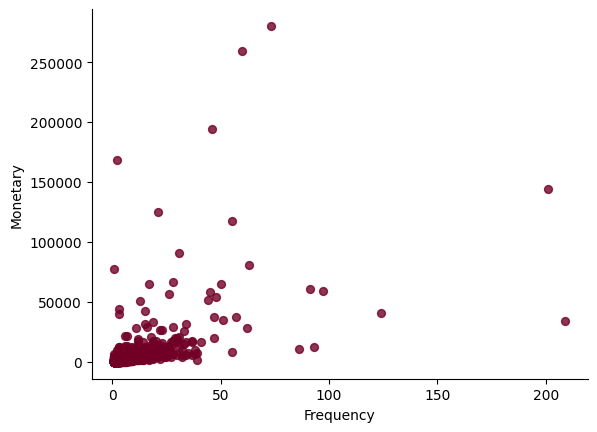

In [37]:
# Frequency vs Monetary plot
from matplotlib import pyplot as plt
rfm.plot(kind='scatter', x='Frequency', y='Monetary', s=32, alpha=.8, color = '#720026')
plt.gca().spines[['top', 'right',]].set_visible(False)

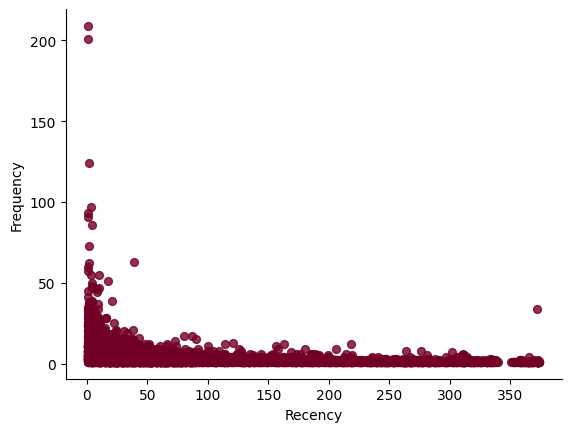

In [38]:
# Recency vs Frequency plot
from matplotlib import pyplot as plt
rfm.plot(kind='scatter', x='Recency', y='Frequency', s=32, alpha=.8, color = '#720026')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [39]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [41]:
# Create bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() - 1, 2, 3, 10, 100, rfm['Frequency'].max()]
monetary_bins = [rfm['Monetary'].min() - 3, 300, 600, 2000, 5000, rfm['Monetary'].max()]

# Calculate RFM scores based on custom bins
rfm['Rec_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=range(1, 6), include_lowest=True)
rfm['Freq_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['Mon_Score'] = pd.cut(rfm['Monetary'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['Rec_Score'] = 5 - rfm['Rec_Score'].astype(int) + 1

print(rfm[['Rec_Score', 'Freq_Score', 'Mon_Score']].head())

            Rec_Score  Freq_Score  Mon_Score
CustomerID                                  
12346               1           1          5
12347               5           3          4
12348               3           3          3
12349               5           1          3
12350               1           1          2


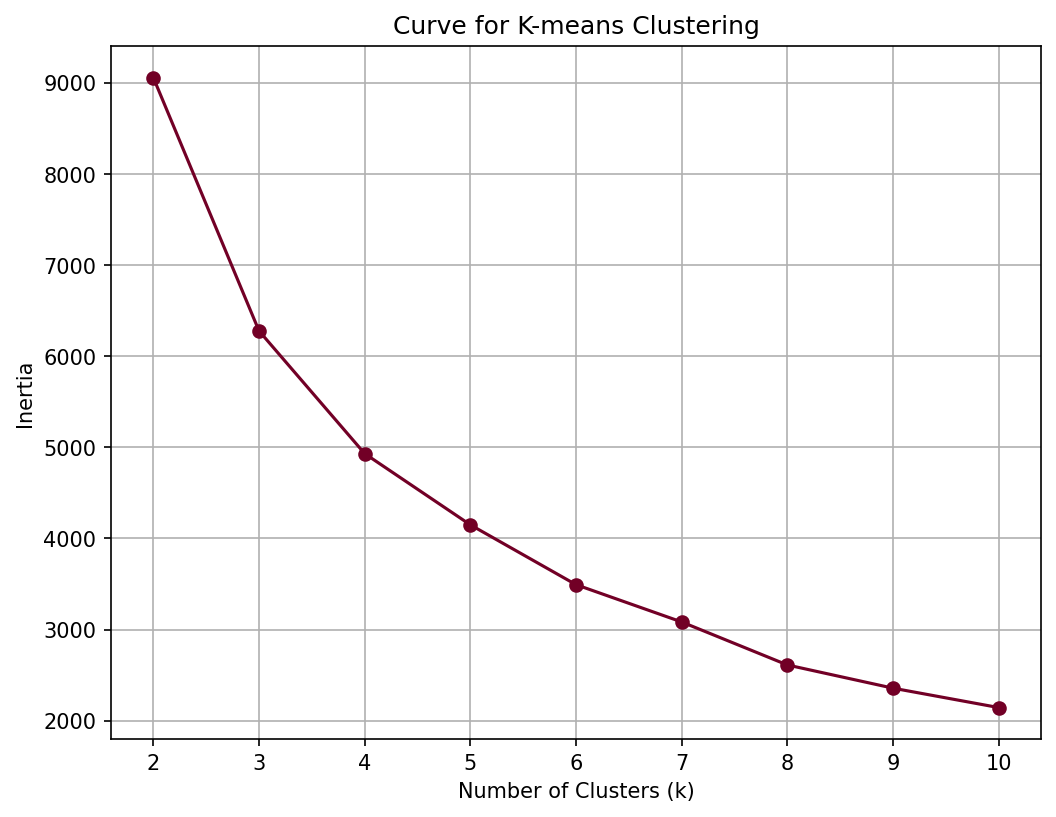

In [42]:
# Set up for K-means clustering
X = rfm[['Rec_Score', 'Freq_Score', 'Mon_Score']]

# Calculate inertia
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=121)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot results
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o', color = '#720026')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Curve for K-means Clustering')
plt.grid(True)
plt.show()

In [44]:
# Perform K-means with clusters = 4
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=121)
rfm['Cluster'] = best_kmeans.fit_predict(X)

# Group by cluster and calculate mean values
k_summary = rfm.groupby('Cluster').agg({
    'Rec_Score': 'mean',
    'Freq_Score': 'mean',
    'Mon_Score': 'mean'
}).reset_index()

print(k_summary)

   Cluster  Rec_Score  Freq_Score  Mon_Score
0        0   4.684377    3.189532   3.754956
1        1   3.886957    1.077470   1.702767
2        2   3.029002    2.090487   3.156613
3        3   1.487368    1.055789   1.642105


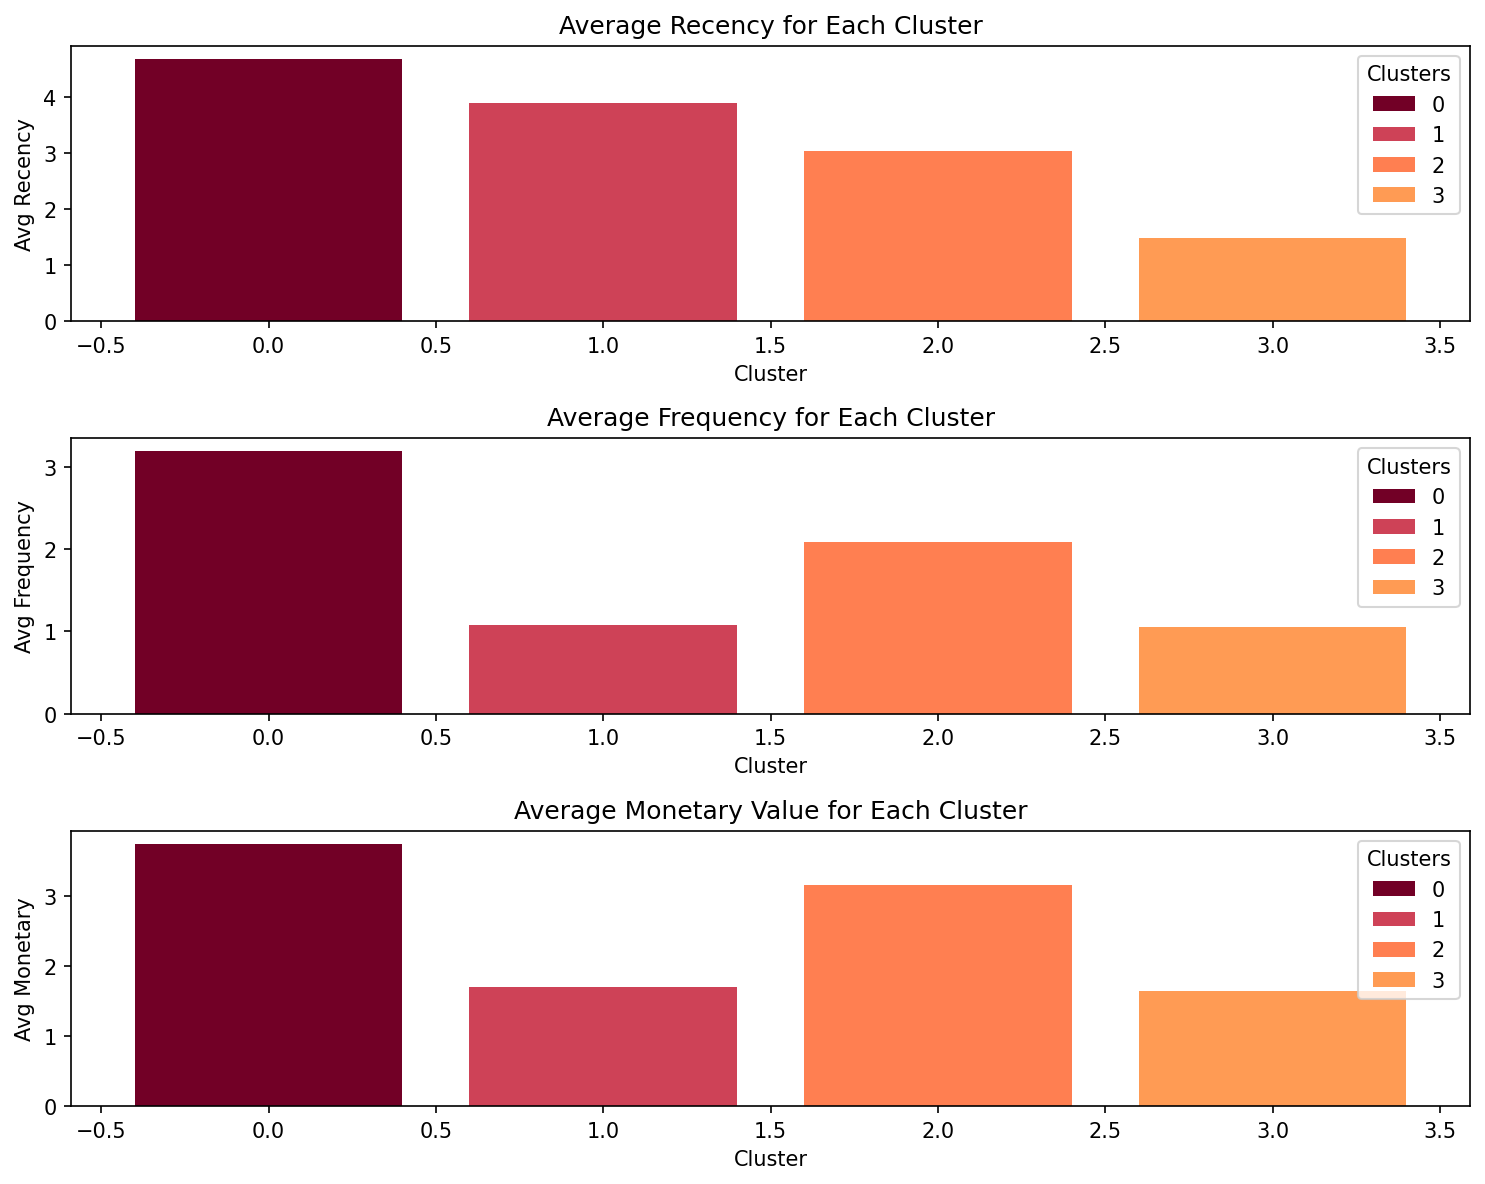

In [45]:
colors = ['#720026', '#CE4257', '#FF7F51','#FF9B54']

plt.figure(figsize=(10, 8),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(k_summary.index, k_summary['Rec_Score'], color=colors)
plt.title('Average Recency for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.legend(bars, k_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(k_summary.index, k_summary['Freq_Score'], color=colors)
plt.title('Average Frequency for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.legend(bars, k_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(k_summary.index, k_summary['Mon_Score'], color=colors)
plt.title('Average Monetary Value for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.legend(bars, k_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

Cluster 0: Highest Recency, Frequency, and Monetary value. These customers shop often and spend a lot of money. We will call this group the "Big Spenders".

Cluster 1: 2nd highest Recency, low Frequency and low Monetary value. These customers are most likely new due to their low monetary values and recent purchases. We will title this group the "New Customers".

Cluster 2: Average Recency, 2nd highest Frequency and Monetary value. These seem to be everyday customers who have this retailer in their list of favorite stores. These will be our "Loyal Customers".

Cluster 3: Lowest Recency, low Frequency and low Monetary value. These are occasional shoppers who do not frequent the retailer very often. Due to their low recency, we will call this group "At-risk Customers".

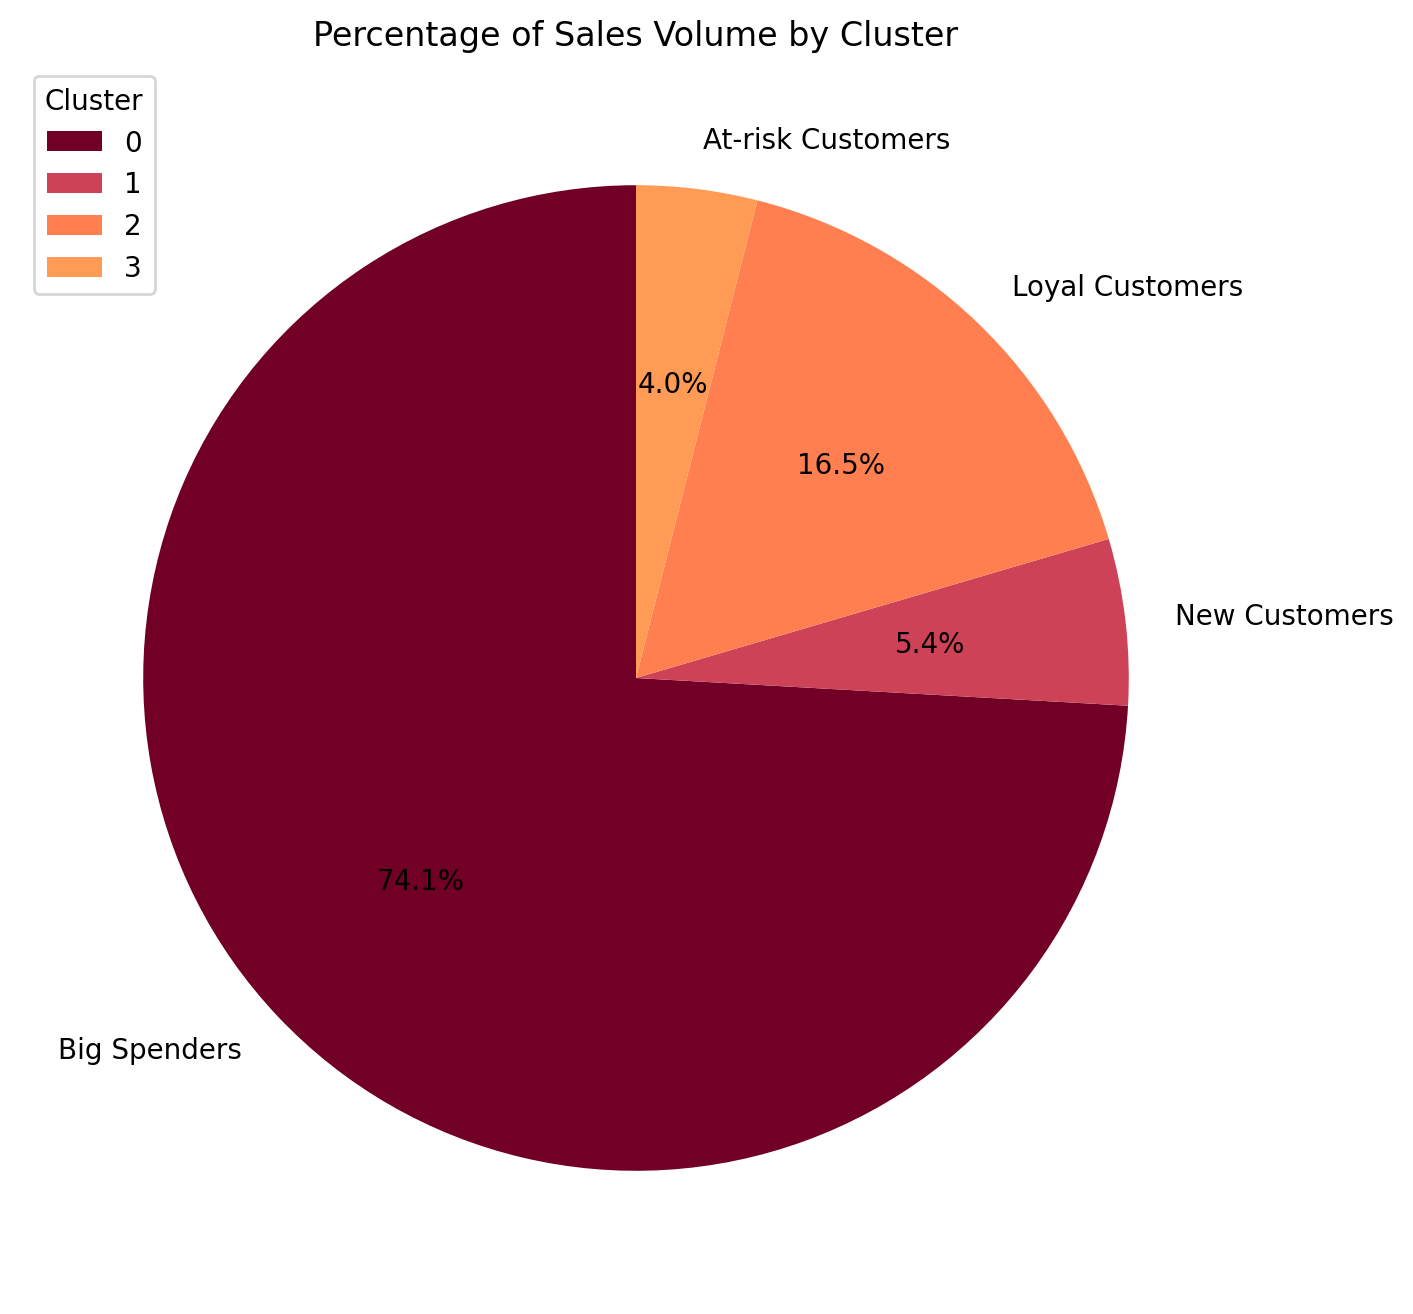

In [60]:
cluster_sales = rfm.groupby('Cluster').agg({
    'Monetary': 'sum'
}).reset_index()

cluster_sales = cluster_sales['Monetary']

colors = ['#720026', '#CE4257', '#FF7F51','#FF9B54']

# Calculate the percentage of customers in each cluster
total_sales = rfm['Monetary'].sum()
percentage_customers = (cluster_sales / total_sales) * 100

labels = ['Big Spenders','New Customers','Loyal Customers','At-risk Customers']

# Create a pie chart
plt.figure(figsize=(8, 8),dpi=200)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Sales Volume by Cluster')
plt.legend(k_summary['Cluster'], title='Cluster', loc='upper left')
plt.show()

# Marketing Plan
In this break down, we can see nearly 3/4 of sales are coming from the Big Spenders population. This is a high-value group we want to hold on to and encourage to come back as frequently as possible. For this group I recommend:

*   Tiered Loyalty Program - Includes rewards to show appreciation for their continued loyalty, higher tiers receive early access to sales and higher rewards
*   Monthly Newsletter - Keep shoppers up-to-date with new releases to encourage more purchases

The second largest contributor to sales are the Loyal Customers. These are your average shoppers who have this retailer in mind when they plan to shop. For this group I recommend:  

*   Tiered Loyalty Program - Includes rewards to show appreciation for their continued loyalty, can encourage extra shopping even if customer stays at a lower or mid-level tier
*   Monthly Newsletter - Keep shoppers up-to-date with new releases to plan for future purchases
*   Discount Codes - Encourage these shoppers to 'splurge' on a more expensive item or to visit the store more frequently

Next, we have our New Customers. This group is not as familiar with our store, so we will need to take a different approach to get them interested in our products. I recommend:

*   New Customer Discount - Encourage customers to return with X% off your next visit  
*   Recommendation emails - Instead of a monthly newsletter, we can begin by tailoring emails to similar items, adjacent products, or complimentary goods
*   Annual Sale - Get these shoppers in-the-know about big events, like annual sales, to plan ahead for

Lastly, we have our At-Risk Customers. These customers do not feel a strong pull towards our store currently, and will need feel valued or incentivized to return. For this group, I recommend:

*   Annual Sale - Let these shoppers know about big events, like annual sales, to encourage a visit to the store
*   Special Discount - Offer these customers a higher % discount to encorage them to take another look at what we have to offer






